Adding stored data to store the trades for calculation of results

In [99]:
# # Install all important libraries
# !pip install yfinance
# !pip install ta

In [100]:
list = ['AAPL', 'AMZN', 'NFLX', 'GOOG']

In [101]:
# import all libraries

from ta.utils import dropna
from ta.volatility import BollingerBands, AverageTrueRange
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


In [102]:
# For event based backtesting, an imporatant concept is a bar.
# A bar is unit of data or information. A bar represents an event.
# Event based Backtesting will be based on new bars coming at not on full dataset.

# First we will build a commonclass,
# this will be utilised for all the common purposes like preparing data, plotting results, placing orders etc

In [103]:
class Common_Class():

  def __init__(self, symbols, start, end, interval, capital, transcation_cost, verbose = True):
    self.symbols = symbols
    self.start = start
    self.end = end
    self.interval = interval
    self.initial_capital = capital  # initial capital
    self.capital = {symbol: capital / len(symbols) for symbol in symbols} # capital assigned to each stock
    self.transaction_cost = transcation_cost # the transaction cost for trading
    self.quantity = {symbol: 0 for symbol in symbols} # quantities to buy/sell
    self.position = {symbol: 0 for symbol in symbols} # the trades in progress, long or short
    self.trades = {symbol: 0 for symbol in symbols} # Number of trades
    self.verbose = verbose # if you want to see detailed output (logs)
    self.stored_data = {symbol: pd.DataFrame(columns=['trade', 'date', 'position', 'price', 
                          'symbol', 'quantity', 'capital']) 
                          for symbol in symbols} # to store trade details
    self.prepare_data() # prepares the data

  def prepare_data(self):
    self.data = {}
    for symbol in self.symbols:
      hist_stock = yf.download(symbol, start = self.start, end = self.end, interval = self.interval)
      
      bt_data = pd.DataFrame()
      bt_data["Adj_Close_Price"] = hist_stock["Adj Close"]
      bt_data["Log Return"] = np.log(bt_data["Adj_Close_Price"] / bt_data["Adj_Close_Price"].shift(1))
      bt_data["High"] = hist_stock["High"]
      bt_data["Low"] = hist_stock["Low"]
      bt_data = bt_data.dropna()
      self.data[symbol] = bt_data
      
  def close_graph(self):
    plt.figure(figsize=(15, 5))
    for symbol in self.symbols:
      plt.plot(self.data[symbol]["Adj_Close_Price"], label=symbol, linestyle='dashed')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title("Adjusted Close Prices of All Stocks")
    plt.legend()
    plt.grid()
    plt.show()

  def return_date_price(self, bar, symbol):

    # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
    # Since we have modeled close prices, we will get the price and date

    date = str(self.data[symbol].index[bar])[:10]
    price = self.data[symbol].Adj_Close_Price.iloc[bar]
    return date, price

  def realised_balance(self, bar):

    # Realised capital in account at a given time period / bar
    total = 0
    for symbol in self.symbols:
      date, price = self.return_date_price(bar, symbol)
      total += self.capital[symbol]
    print("Date :{} | Realised Balance: {:0.1f}".format(date, total))

  def unrealised_balance(self, bar):

    #Returns you the unrealised capital (trades in progress) in your account at a given time period / bar
    total_ub = 0
    for symbol in self.symbols:
      date, price = self.return_date_price(bar, symbol)
      total_ub += self.quantity[symbol] *price
    print("Date :{} | Unrealised Balance: {:0.1f}".format(date, total_ub))

  def total_balance(self, bar):

    #Unrealised plus realised
    tb = 0
    for symbol in self.symbols:
      date, price = self.return_date_price(bar, symbol)
      tb += self.quantity[symbol] *price + self.capital[symbol]

    print("Date :{} | Total Balance: {:0.1f}".format(date, tb))

  def store_results(self, trade, date, position, price, symbol, quantity, capital):
    trade_detail = pd.DataFrame({'trade':pd.Series(trade), 'date':pd.Series(date), 'position':pd.Series(position), 'price':pd.Series(price), 'symbol':pd.Series(symbol), 'quantity':pd.Series(quantity), 'capital':pd.Series(capital) })
    self.stored_data[symbol] = pd.concat([self.stored_data[symbol], trade_detail])

  def performance(self):

    # Creating a temporary variable B to do all calculations
    # I could have also copied stored data, but I like single letter variables ( not recommended)
    final_df = pd.DataFrame()
    for symbol in self.symbols:
      B = self.stored_data[symbol]
      B.index = range(B.shape[0]) # shape[0] to get the length of rows
      #Preparing metrics to calculate performance
      B['exit_date'] = B['date'].shift(-1) # The data was stored as a series of Buy / Sell or Sell / Buy in order
      B['exit_price'] = B['price'].shift(-1)
      B['capital_after_settlement'] = B['capital'].shift(-1)
      final_df = pd.concat([final_df, B], ignore_index=True)

    final_df = final_df.drop_duplicates(subset=['symbol', 'date'], keep='last').reset_index(drop=True)
    grouped_df = final_df.groupby(['exit_date'])['capital_after_settlement'].sum().reset_index()
    final_df.drop(columns=['capital_after_settlement'], inplace=True)
    final_df = final_df.merge(grouped_df, on='exit_date')
    final_df.sort_values(by='exit_date', inplace=True)
    # Since we are are utilising capital, we will calculate returns for SR based on daily capital/equity changes
    # Remember, you can change the returns on investment based on the amount/capital you trade. So, its not like all returns are realised
    Final_result_data = final_df.drop_duplicates(subset='exit_date', keep='last').reset_index(drop=True)
    Final_result_data['capital_regular_returns'] = (Final_result_data['capital_after_settlement']/Final_result_data['capital_after_settlement'].shift(1) - 1)
    Final_result_data['capital_log_returns'] = np.log(Final_result_data['capital_after_settlement']/Final_result_data['capital_after_settlement'].shift(1))
    Final_result_data["capital_returns_log_cum_sum"] = Final_result_data["capital_log_returns"].cumsum()
    Final_result_data.drop(Final_result_data.index[Final_result_data['capital_log_returns'] == 0.0], inplace=True) #Dropping the last column, as I already got the values through shift(1)
    Final_result_data = Final_result_data.dropna()

    #arranging the columns for better readeability
    cols =['trade','symbol','position','quantity','date', 'exit_date', 'price','exit_price','capital','capital_after_settlement', 'capital_regular_returns', 'capital_log_returns', 'capital_returns_log_cum_sum']
    Final_result_data = Final_result_data[cols]
    Final_result_data.rename(columns = {'date':'entry_date', 'price':'entry_price'}, inplace = True)

    #Plot the equity curve
    plt.plot(Final_result_data['exit_date'],Final_result_data['capital_after_settlement'])

    # Annual gross expected returns
    daily_log_mean_ret = Final_result_data['capital_log_returns'].mean()
    annual_log_ret = 252 * daily_log_mean_ret
    annual_regular_return = (np.exp(annual_log_ret) -1)*100
    print("The annual regular returns are {:0.2f} %".format(annual_regular_return))

    # Annual std deviation
    daily_regular_std = (np.exp(Final_result_data['capital_log_returns'])-1).std()
    annual_regular_std =  daily_regular_std * (252 **0.5) *100
    print("The annual regular std deviation  is {:0.2f} %".format(annual_regular_std))

    #Annual Sharpe Ratio
    SR = annual_regular_return / annual_regular_std
    print("The annual Sharpe Ratio is {:0.2f}".format(SR))

    #The strategy returns on investment in percent
    Total_Log_ret = Final_result_data['capital_log_returns'].sum()
    Total_Log_ret
    Regular_ROI = (np.exp(Total_Log_ret) - 1) *100
    print("The returns on investment from {} to {} by this strategy is {:0.1f} %".format(self.start, self.end, Regular_ROI))

    Final_result_data['cumulative_capital_returns'] = Final_result_data['capital_log_returns'].cumsum().apply(np.exp)
    Final_result_data['maximum_returns'] = Final_result_data['cumulative_capital_returns'].cummax()
    Final_result_data['max_drawdown'] = Final_result_data['maximum_returns'] - Final_result_data['cumulative_capital_returns']
    max_drawdown = Final_result_data['max_drawdown'].max()

    plt.figure(figsize=(12, 6))
    plt.plot(Final_result_data['exit_date'], Final_result_data['cumulative_capital_returns'], label='Cumulative Returns')
    plt.plot(Final_result_data['exit_date'], Final_result_data['maximum_returns'], label='Maximum Returns')
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.title("Cumulative Capital Returns and Maximum Returns")
    plt.legend()
    plt.show()

    print("The maximum drawdown is {:0.2f}".format(max_drawdown))

    calmar_ratio = (annual_regular_return/ 100) / max_drawdown
    print("The calmar ratio is {:0.2f}".format(calmar_ratio))

    #print("The histogram of returns")
    #Final_result_data['capital_log_returns'].hist(bins= 40)


  def buy_order(self,bar, symbol, quantity=None, dollar =None, ):
    date, price = self.return_date_price(bar, symbol)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital[symbol] = self.capital[symbol] - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
    self.quantity[symbol] = self.quantity[symbol] + quantity
    self.trades[symbol] = self.trades[symbol] + 1
    self.position[symbol] = 1 #(To be stored in results. Will need for calculations)
    self.store_results(self.trades[symbol], date, self.position[symbol], price, symbol, quantity, self.quantity[symbol]*price + self.capital[symbol])


    if self.verbose:
      print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity, symbol, price, quantity * price))
      self.realised_balance(bar)
      self.unrealised_balance(bar)
      self.total_balance(bar)


  def sell_order(self,bar, symbol, quantity=None, dollar=None ):
    date, price = self.return_date_price(bar, symbol)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital[symbol] = self.capital[symbol] + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
    self.quantity[symbol] = self.quantity[symbol] - quantity
    self.trades[symbol] = self.trades[symbol] + 1
    self.position[symbol] = -1
    self.store_results(self.trades[symbol], date, self.position[symbol], price, symbol, quantity, self.quantity[symbol]*price + self.capital[symbol])

    if self.verbose:
      print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity, symbol, price, quantity * price))
      self.realised_balance(bar)
      self.unrealised_balance(bar)
      self.total_balance(bar)

  def last_trade(self, bar):
    current_capital = 0
    total_trades = 0
    for symbol in self.symbols:
      date, price = self.return_date_price(bar, symbol)
      last_quantity = self.quantity[symbol]
      self.capital[symbol] = self.capital[symbol] + last_quantity * price
      self.quantity[symbol] = 0 # as no more quantity now. all will be settled
      self.trades[symbol] = self.trades[symbol] +1
      if self.position[symbol] == -1: # if closing out a short position
        last_quantity = - last_quantity # to keep a positve nymber in records
        self.position[symbol] = 1 # to record we are buying to close out
      else:
        last_quantity =  last_quantity # to keep a positve nymber in records
        self.position[symbol] = -1 # to record we are selling to close out
      #self.position = 0

      self.store_results(self.trades[symbol], date, self.position[symbol], price, symbol, last_quantity, self.quantity[symbol]*price + self.capital[symbol])
      current_capital += self.capital[symbol]
      total_trades += self.capital[symbol]

    print("=" *50)
    print("--------------Final Balance-----------")
    self.total_balance(bar)
    print("=" *50)

    if self.verbose:
      print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity, symbol, price, last_quantity * price))
      print("--------------Final Balance-----------")
      self.total_balance(bar)
      
      returns = (current_capital - self.initial_capital) /self.initial_capital * 100
      print("------------------------------")
      print("The total capital at end of strategy: {:0.1f}".format(current_capital))
      print( "The strategy returns on investment are {:0.1f} %".format(returns))
      print( "Total trades by startegy are {:0.1f}".format(total_trades))


In [104]:
class Strategy2(Common_Class):

  def go_long(self, bar, symbol, quantity = None, dollar = None): # either previously in position or fresh position
    if self.position[symbol] == -1:
      self.position[symbol] = 0
      self.buy_order(bar, symbol, quantity = -self.quantity[symbol]) #to clear previous short position and therefore negative quantity.(already in position, thats why negative)
    if quantity:
      self.buy_order(bar, symbol, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital[symbol]
      self.buy_order(bar, symbol, dollar = dollar)


  def go_short(self, bar, symbol, quantity = None, dollar = None):
    if self.position[symbol] == 1:
      self.position[symbol] = 0
      self.sell_order(bar, symbol, quantity = self.quantity[symbol]) #to clear previous long vposition
    if quantity:
      self.sell_order(bar, symbol, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital[symbol]
      self.sell_order(bar, symbol, dollar = dollar)

  def calculate_bollinger_bands(self, symbol, bb_window, bb_std):
    bb_indicator = BollingerBands(close=self.data[symbol]['Adj_Close_Price'], window=bb_window, window_dev=bb_std)
    self.data[symbol]['Upper_Band'] = bb_indicator.bollinger_hband()
    self.data[symbol]['Lower_Band'] = bb_indicator.bollinger_lband()
    self.data[symbol]['Moving_Average'] = bb_indicator.bollinger_mavg()

  def calculate_RSI(self, symbol, rsi_window):
    rsi_indicator = RSIIndicator(close = self.data[symbol]['Adj_Close_Price'], window=rsi_window, fillna=False)
    self.data[symbol]['RSI'] = rsi_indicator.rsi()

  def calculate_ATR(self, symbol, atr_window):
    atr_indicator = AverageTrueRange(high=self.data[symbol]['High'], low=self.data[symbol]['Low'], close=self.data[symbol]['Adj_Close_Price'], window=atr_window)
    self.data[symbol]['ATR'] = atr_indicator.average_true_range()

  def run_strategy(self, bb_window, bb_std, rsi_window, atr_window): 
    for symbol in self.symbols:# add the parameters according to the strategy
      self.position[symbol] = 0
      self.trades[symbol] = 0
      self.capital[symbol] = self.capital[symbol]

      self.calculate_bollinger_bands(symbol, bb_window, bb_std)
      self.calculate_RSI(symbol, rsi_window)
      self.calculate_ATR(symbol, atr_window)

      initial_bar = max(bb_window, max(atr_window, rsi_window))
      atr_threshold = self.data[symbol]['ATR'].quantile(0.75)

      for bar in range(initial_bar, len(self.data[symbol])): # from the available data bar to the last data bar
        date, price = self.return_date_price(bar, symbol)

        if self.position[symbol] in [0,-1]: # checking no position or short position
          if self.data[symbol]["RSI"].iloc[bar] < 30 and self.data[symbol]["Adj_Close_Price"].iloc[bar] < self.data[symbol]["Lower_Band"].iloc[bar]:
            self.go_long(bar, symbol, dollar=5000) # go with all money # Make sure to enter less than initila capital
            #print("--------")
            continue # as I am storing data for SR calculations. Dont want duplication. Continue to make sure 0 is added only on no conditions day

        if self.position[symbol] in [0,1]: # checking no position or long position
          if self.data[symbol]["RSI"].iloc[bar] > 70 and self.data[symbol]["Adj_Close_Price"].iloc[bar] > self.data[symbol]["Upper_Band"].iloc[bar] and self.data[symbol]["ATR"].iloc[bar] > atr_threshold :
            self.go_short(bar, symbol, dollar =5000) # go with all money
            #print("--------")
            continue

        #-----Storing all the values for calculating Sharpe-----
        store_quantity = abs(self.quantity[symbol]) # so that I want just the positive numbers in my performance table. I will calculate +/- based on self.position sign
        self.store_results(0, date, self.position[symbol], price, symbol, store_quantity, self.quantity[symbol]*price + self.capital[symbol])

    print("=" *50)
    print("End of last bar")
    print("=" *50)
    self.last_trade(bar)  # amke sure the crossover happens, give more time
    #print(self.stored_data.to_string())
    for symbol in self.symbols:
      print(self.stored_data[symbol])

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


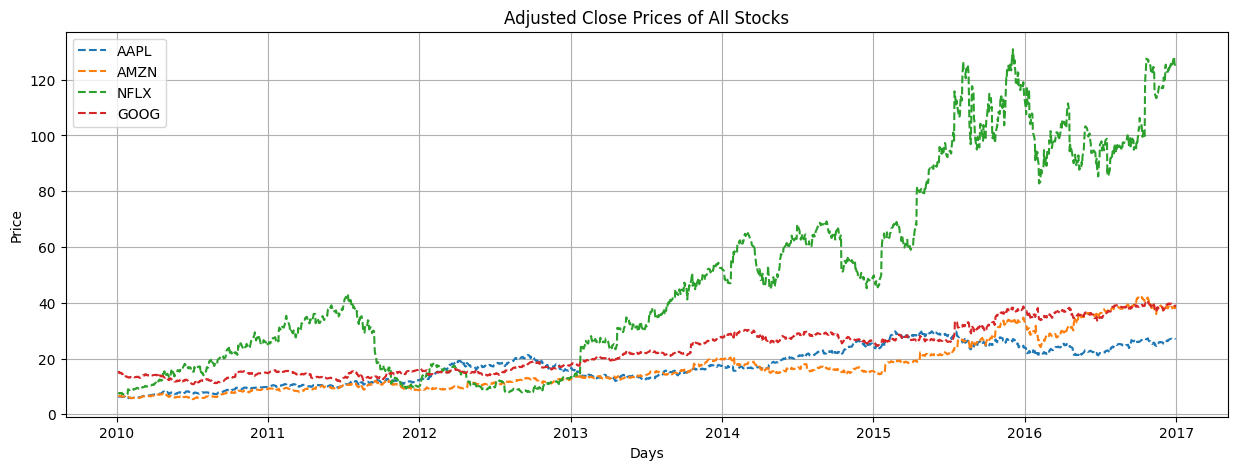

C:\Users\chuac\AppData\Local\Temp\ipykernel_43032\572875779.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stored_data[symbol] = pd.concat([self.stored_data[symbol], trade_detail])
C:\Users\chuac\AppData\Local\Temp\ipykernel_43032\572875779.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stored_data[symbol] = pd.concat([self.stored_data[symbol], trade_detail])
C:\Users\chuac\AppData\Local\Temp\ipykernel_43032\572875779.py:83: FutureWarning: The behavior of DataFrame concaten

End of last bar
--------------Final Balance-----------
Date :2016-12-30 | Total Balance: 56624.3
   trade        date position      price symbol quantity       capital
0      0  2010-02-04        0   5.792196   AAPL        0  12500.000000
0      0  2010-02-05        0   5.895040   AAPL        0  12500.000000
0      0  2010-02-08        0   5.854625   AAPL        0  12500.000000
0      0  2010-02-09        0   5.917057   AAPL        0  12500.000000
0      0  2010-02-10        0   5.884786   AAPL        0  12500.000000
..   ...         ...      ...        ...    ...      ...           ...
0      0  2016-12-27        1  27.178827   AAPL      214  17071.277988
0      0  2016-12-28        1  27.062933   AAPL      214  17046.476604
0      0  2016-12-29        1  27.055983   AAPL      214  17044.989223
0      0  2016-12-30        1  26.845057   AAPL      214  16999.851048
0      8  2016-12-30       -1  26.845057   AAPL      214  16999.851048

[1744 rows x 7 columns]
   trade        date posit

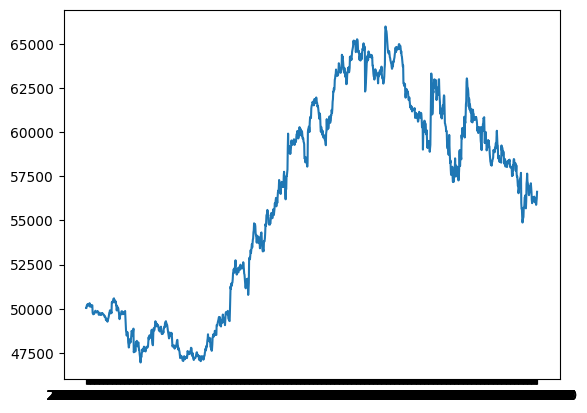

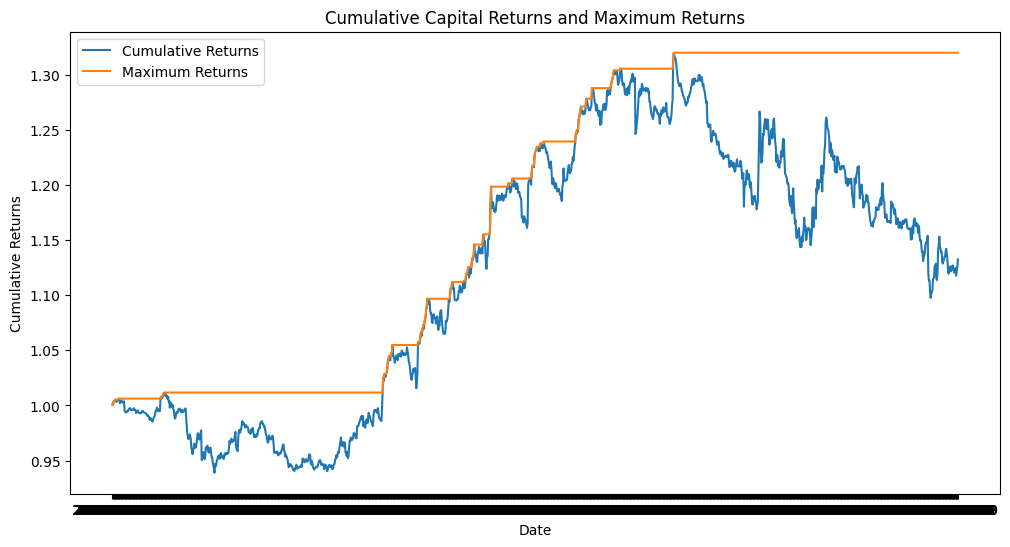

The maximum drawdown is 0.22
The calmar ratio is 0.10


In [105]:
if __name__ == "__main__":
  A = Strategy2(list, "2010-01-01", "2017-01-01","1d",50000, 0.0, False)
  A.close_graph()
  A.run_strategy(20, 2, 21, 14)
  A.performance()